# What is my goal with this project?
As a citizen of Porto Alegre for more than 25 years I started to have the feeling that our weather is changing a little on these last years. Out of curiosity I wanted to visualize what differences are perceptible.

This is a simple project intended only to consolidate my knowledge of pandas, matplotlib and seaborn as I'm currently deepening my comprehension of them.

### Dataset index & columns
0. date: from 2001-01-01 to 2022-03-10. As index.
1. total_precip: daily total precipitation.
2. max_temp: daily maximum temperature.
3. avg_temp: daily average temperature.
4. min_temp: daily minimum temperature.
5. avg_humidity: daily average humidity.
6. min_humidity: daily minimum humidity.

### What steps will be done:
* Data extraction: load .csv
* Data preparation: clean useless cols & rows, simplify & translate cols, convert data types, decrease the amount of NaN, date as index, drop NaN
* Visualization: 

### Which questions I want to answer?

#### Summer

* Did the avg temp rose up in these last years?
* Did the max temp rose up?

#### Winter

* Did the mean temperature had any change?
* Did the min temperature decreased?

#### Precipitation

* Did the monthly precipitations sums had suffered some kind of change trough the years?

#### Humidity

* Did the humidity monthly means suffered any changes along these years? Does it follows the changes of other variables?

In [2]:
import numpy as np
import pandas as pd
import datetime

# Data extraction
I got this .csv file with historical data from Porto Alegre from the INMET (Instituto Nacional de Meteorologia) website. It's very simple to get the data in the way you want (specific variables, date range, etc). You can go to https://bdmep.inmet.gov.br/ (the INMET database website) and ask for it, it gives you many options to customise your data and the dataset will be sent via e-mail.

In [3]:
# [Po]rto [A]legre [W]eather dataframe being loaded from the csv with ';' as separator
poaw = pd.read_csv('DATA_POA_2001-01-01_2022-03-11.csv',sep=';')
poaw.head()

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (mm)","TEMPERATURA MAXIMA, DIARIA (C)","TEMPERATURA MEDIA, DIARIA (C)","TEMPERATURA MINIMA, DIARIA (C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (%)",Unnamed: 7
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0,NaN
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0,NaN
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0,NaN
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0,NaN
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0,NaN


# Data preparation
What will be done:
* Drop the useless cols
* Simplify and translate cols names
* Convert str data types to datetime (date) and to float (others)

#### Drop the useless cols

In [4]:
# Drop the last and useless column
poaw.drop(labels='Unnamed: 7',axis=1,inplace=True)

#### Simplify and translate cols names

In [5]:
# For simplification and translation purposes I will change the columns names
new_col_names = ['date',
                 'total_precip',
                 'max_temp','avg_temp',
                 'min_temp',
                 'avg_humidity',
                 'min_humidity']

poaw.columns = new_col_names

In [6]:
poaw.head()

,date,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0


#### Convert str data types to datetime (date) and to float (others)

In [7]:
# Convert the "Date" col to datetime type and the other cols to float type (the last col is already float)
poaw['date'] = pd.to_datetime(poaw['date'])

# List with all the cols to be changed from str to float
cols_to_float = ['total_precip', 'max_temp', 'avg_temp', 'min_temp', 'avg_humidity']

poaw[cols_to_float] = poaw[cols_to_float].apply(lambda x: x.str.replace(',','.').astype(float))

#Non used trash
#poaw['Max Temp'] = poaw.iloc[:,2:3].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Average Temp'] = poaw.iloc[:,3:4].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Min Temp'] = poaw.iloc[:,4:5].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Avg Relative Humidity'] = poaw.iloc[:,5:6].apply(lambda x: x.str.replace(',','.').astype(float))

#### Decrease the amount of NaN
In an attempt to decrease the amount of NaN and trying to lose the least amount of rows, I try to make the average from min and max temperature and replace the NaN of the avg_temp with it, in the cols where I have min & max temp but not avg.

In [8]:
poaw.isna().sum()

date              0
total_precip    530
max_temp        292
avg_temp        508
min_temp        287
avg_humidity    211
min_humidity    112
dtype: int64

In [9]:
# Here I look for the rows which avg_temp is NaN and that max_temp & min_temp exists
# From this I replace the NaN with the arithmetic mean between max and min temperatures of that day
poaw.loc[poaw['max_temp'].notnull() 
         & poaw['min_temp'].notnull() 
         & poaw['avg_temp'].isnull(),'avg_temp'] = (poaw['max_temp'] + poaw['min_temp']) / 2

poaw.isna().sum()

date              0
total_precip    530
max_temp        292
avg_temp        314
min_temp        287
avg_humidity    211
min_humidity    112
dtype: int64

#### Dropping non-useful rows
As I don't plan right now to apply ML models on this dataset the best choice for the rows that contain too mmany NaNs is to drop it commpletely

In [10]:
#Droping rows where there are at least 4 non-NaN
poaw.dropna(thresh=4, inplace=True)

In [11]:
poaw.isna().sum()

date              0
total_precip    274
max_temp         35
avg_temp         58
min_temp         51
avg_humidity      2
min_humidity     28
dtype: int64

#### Creating 'year', 'month' and 'day' cols

In [12]:
poaw['year'] = pd.DatetimeIndex(poaw['date']).year
poaw['month'] = pd.DatetimeIndex(poaw['date']).month
poaw['day'] = pd.DatetimeIndex(poaw['date']).day

#### Set date as index

In [13]:
#Setting the date as index
poaw.set_index('date',inplace=True)

poaw.head()

,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity,year,month,day
date,,,,,,,,,
2001-01-01,0.0,30.1,23.616667,18.4,68.458333,48.0,2001,1,1
2001-01-02,0.0,32.1,25.475000,20.0,69.958333,45.0,2001,1,2
2001-01-03,0.0,33.4,26.345833,21.0,69.083333,43.0,2001,1,3
2001-01-04,0.0,35.5,27.429167,21.2,65.041667,37.0,2001,1,4
2001-01-05,0.0,35.6,27.637500,24.6,67.250000,35.0,2001,1,5


In [14]:
## used to get the % of NAs
## poaw['avg_temp'].value_counts(normalize=True,dropna=False)

In [15]:
## null_list = poaw[poaw['avg_temp'].isnull()].index.tolist()
## filled = poaw[['max_temp','avg_temp','min_temp']].fillna(method='ffill')

# Visualizing

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke

In [17]:
BROWN = "#AD8C97"
BROWN_DARKER = "#7d3a46"
GREEN = "#2FC1D3"
BLUE = "#076FA1"
GREY = "#C7C9CB"
GREY_DARKER = "#5C5B5D"
RED = "#E3120B"

In [18]:
# Separating by summers, winters and years (in the south hemisphere)
summer_start, summer_end = '-12-21', '-03-20'
winter_start, winter_end = '-05-21', '-09-22'
year_start, year_end = '-01-01', '-12-31'


# Initializing with 0 to make the index of years to reflect the year's number 
# as my data starts from 2001 (e.g. 2001 -> [1], 2015 -> [15])
summers = [0]
winters = [0]
years = [0]

year = 2000

for i in range(1,23):
    
    year_i = str(year + i)
    
    summers.append(poaw.loc[year_i + summer_start:str(year+i+1) + summer_end]) #Correction bcause the summer ends in next year
    winters.append(poaw.loc[year_i + winter_start:year_i + winter_end])
    years.append(poaw.loc[year_i + year_start:year_i + year_end])


In [19]:
# As an example, I show the 2001's summer data
summers[1]

,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity,year,month,day
date,,,,,,,,,
2001-12-21,10.8,33.7,23.445833,16.7,75.000000,45.0,2001,12,21
2001-12-22,16.0,22.8,20.458333,19.7,89.458333,80.0,2001,12,22
2001-12-23,0.0,26.1,21.362500,17.0,68.833333,38.0,2001,12,23
2001-12-24,0.0,25.5,20.791667,15.7,65.875000,42.0,2001,12,24
2001-12-25,0.0,28.1,22.354167,18.2,61.625000,40.0,2001,12,25
...,...,...,...,...,...,...,...,...,...
2002-03-16,0.0,36.0,29.450000,23.5,61.708333,42.0,2002,3,16
2002-03-17,0.0,34.8,27.404167,25.8,72.291667,49.0,2002,3,17
2002-03-18,4.4,30.7,25.066667,21.4,79.458333,56.0,2002,3,18


In [37]:
# Creating year statistics table with summers and winters data inside
seasons = pd.DataFrame(index=range(2001,2022),columns=['SUM_temp',
                                                       'SUM_max','SUM_max_avg',
                                                       'SUM_min','SUM_min_avg',
                                                       'SUM_hum','SUM_hum_min',
                                                       'WIN_temp',
                                                       'WIN_max','WIN_max_avg',
                                                       'WIN_min','WIN_min_avg',
                                                       'win_hum','WIN_hum_min'], dtype=np.float64)

# My intention with using this cols var is to make possible to immediately
# change the cols name changing themm in only one place: in the df declaration
cols = seasons.columns

for i in range(1,22):
    
    year = 2000 + i
    
    # Values for summer cols of 'seasons'
    seasons.loc[year, cols[0]] = summers[i]['avg_temp'].mean()
    seasons.loc[year, cols[1]] = summers[i]['max_temp'].max()
    seasons.loc[year, cols[2]] = summers[i]['max_temp'].mean()
    seasons.loc[year, cols[3]] = summers[i]['min_temp'].min()
    seasons.loc[year, cols[4]] = summers[i]['min_temp'].mean()
    seasons.loc[year, cols[5]] = summers[i]['avg_humidity'].mean()
    seasons.loc[year, cols[6]] = summers[i]['avg_humidity'].min()

    
    # Values for winters cols of 'seasons'
    seasons.loc[year, cols[7]] = winters[i]['avg_temp'].mean()
    seasons.loc[year, cols[8]] = winters[i]['max_temp'].max()
    seasons.loc[year, cols[9]] = winters[i]['max_temp'].mean()
    seasons.loc[year, cols[10]] = winters[i]['min_temp'].min()
    seasons.loc[year, cols[11]] = winters[i]['min_temp'].mean()
    seasons.loc[year, cols[12]] = winters[i]['avg_humidity'].mean()
    seasons.loc[year, cols[13]] = winters[i]['avg_humidity'].min()

# For simplicity reasons I round the numbers to 1 decimal place
seasons = seasons.round(1)






In [38]:
seasons

,SUM_temp,SUM_max,SUM_max_avg,SUM_min,SUM_min_avg,SUM_hum,SUM_hum_min,WIN_temp,WIN_max,WIN_max_avg,WIN_min,WIN_min_avg,win_hum,WIN_hum_min
2001,24.7,37.9,30.6,14.9,20.6,69.8,49.9,16.7,30.9,21.9,2.6,12.8,77.1,58.3
2002,25.5,38.0,31.2,15.7,21.1,71.4,50.7,15.7,33.7,20.6,3.4,12.0,77.3,55.8
2003,23.9,35.8,29.8,15.1,19.7,70.3,55.6,15.3,34.5,20.6,3.0,11.3,76.2,53.5
2004,24.6,39.4,30.9,15.0,20.2,67.8,45.7,15.6,36.7,21.0,2.7,11.5,76.9,45.2
2005,24.6,38.7,30.5,13.5,20.6,70.9,53.1,16.3,31.9,21.5,1.9,12.5,77.3,49.5
2006,24.9,35.8,30.5,15.1,20.7,72.0,52.5,15.9,32.3,21.2,2.7,12.1,77.4,55.1
2007,24.2,37.3,30.1,14.4,20.1,71.4,56.5,14.6,33.2,19.7,2.2,10.8,78.3,48.3
2008,23.7,35.3,29.2,13.9,19.8,73.3,55.2,14.9,31.8,19.8,2.3,11.4,78.3,57.1
2009,25.2,38.5,30.7,13.7,21.5,74.0,52.4,14.8,33.4,19.9,0.3,10.9,77.6,42.4
2010,24.5,36.2,30.1,14.1,21.0,75.5,63.0,15.3,32.9,20.2,2.8,11.8,78.6,58.0


### Columns explanation:
* SUM : Summer
* WIN : Winter
* SUM/WIN_temp --> The average for that summer's/winter's temperatures
* SUM/WIN_max --> The highest temperature for that summer/winter
* SUM/WIN_min --> The lowest temperature for that summer/winter
* SUM/WIN_max_avg --> The average for that summer's/winter's daily maximum temperatures
* SUM/WIN_min_avg --> The average for that summer's/winter's daily minimum temperatures
* SUM/WIN_hum --> The average of the daily humidities of that summer/winter
* SUM/WIN_hum_min --> The lowest humidity of that summer/winter

### Visualizations

In [39]:
seasons.head(1)

,SUM_temp,SUM_max,SUM_max_avg,SUM_min,SUM_min_avg,SUM_hum,SUM_hum_min,WIN_temp,WIN_max,WIN_max_avg,WIN_min,WIN_min_avg,win_hum,WIN_hum_min
2001,24.7,37.9,30.6,14.9,20.6,69.8,49.9,16.7,30.9,21.9,2.6,12.8,77.1,58.3


In [40]:
sum_plot = seasons[['SUM_min_avg', 'SUM_temp', 'SUM_max_avg']]
win_plot = seasons[['WIN_min_avg', 'WIN_temp', 'WIN_max_avg']]

Text(0.5, 0.93, "Porto Alegre's SUMMER statistics by year")

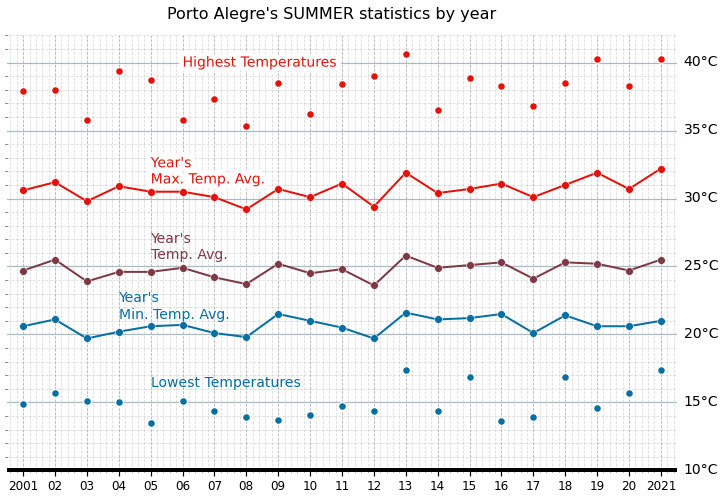

In [59]:
# These are the colors I use along this plot
COLORS = [BLUE, BROWN_DARKER, RED]
# These are the year indexes of seasons dataframe
list_years = list(seasons.index)

# I use this list and for to make a list of the years
# like 01, 02, 03,..., 20, 21
two_digit_years = []
for year in list_years:
    two_digit_years.append(str(year)[2:])
two_digit_years[0] = '2001' # With this will be easier
                            # for the user to understand
two_digit_years[20] = '2021'# the x axis

# Initialize plot -----------
fig, ax = plt.subplots(figsize=(12,8))


# Add lines with dots
for temperature, color in zip(sum_plot,COLORS):
    ax.plot(list(list_years), seasons[temperature], color=color,lw=2)
    ax.scatter(list(list_years), seasons[temperature], fc=color, s=60, lw=0.5,ec='white',zorder=12)
ax.scatter(list(list_years), seasons['SUM_max'], fc=RED,s=60,lw=1.2,ec='white',zorder=12)
ax.scatter(list(list_years), seasons['SUM_min'], fc=BLUE,s=60,lw=1.2,ec='white',zorder=12)
    
# Customize axis -----------
# Customize y-axis ticks
ax.yaxis.set_ticks([i * 5 for i in range(2,9)])
ax.yaxis.set_ticklabels([i * 5 for i in range(2,9)])
ax.yaxis.set_tick_params(labelleft=False, length=0)

# Customize x-axis ticks
ax.xaxis.set_ticks(list_years)
ax.xaxis.set_ticklabels(two_digit_years,
                        fontsize=12, fontfamily="Econ Sans Cnd", 
                        fontweight=50)
ax.xaxis.set_tick_params(length=6, width=1.2)

# Make gridlines be below most axis
ax.set_axisbelow(True)

# Add grid lines 
ax.grid(axis = 'y', color='#A8BAC4', lw=1.2)
ax.grid(axis = 'x' ,linestyle='--', lw=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='--', alpha=0.35)

# Remove all spines but the one in the bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize bottom spine
ax.spines['bottom'].set_lw(4)
ax.spines['bottom'].set_capstyle('butt')

# Set custom limits
ax.set_ylim(10,42)
ax.set_xlim(2000.5,2021.5)

# Add labels for verticcal grid lines ---------
# The pad is equal to 1% of the vertical range (17 - 35)
PAD = 18 * 0.01
for label in [i * 5 for i in range(2,9)]:
    ax.text(2022.8, label - 0.2, str(label) + '°C',
           ha='right',va='baseline', fontsize=14,
           fontweight=100)
    
# Annotate labels for variable names ---------

# Note the path effecct must be a list
path_effects = [withStroke(linewidth=10, foreground='white')]

# We create a function to avoid repeating 'ax.text' many times
def add_var_label(x, y, text, color, path_effects, ax):
    '''This function create a label with defined position and 
    arguments so we dont need to repeat ax.text many times'''
    ax.text(x,y,
           text, color=color,
           fontsize=14,
           va='center', ha='left',
           path_effects=path_effects)
var_labels = [
    {
        'x':2006,'y':40,'text':"Highest Temperatures",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':32,'text':"Year's\nMax. Temp. Avg.",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':26.5,'text':"Year's\nTemp. Avg.",
        'color': BROWN_DARKER, 'path_effects': []},
    {
        'x':2004,'y':22.1,'text':"Year's\nMin. Temp. Avg.",
        'color': BLUE, 'path_effects': []},
    {
        'x':2005,'y':16.5,'text':"Lowest Temperatures",
        'color': BLUE, 'path_effects': []}
]

for label in var_labels:
    add_var_label(**label,ax=ax)
    
plt.suptitle("Porto Alegre's SUMMER statistics by year",y=0.93,fontsize=16)


Text(0.5, 0.93, "Porto Alegre's WINTER statistics by year")

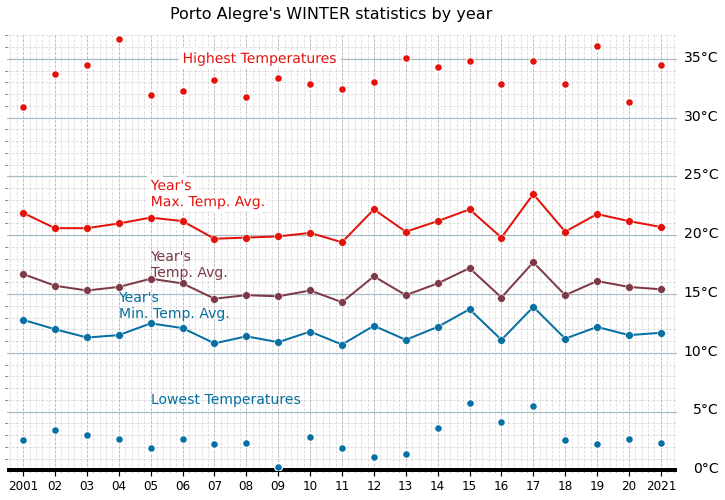

In [58]:
# These are the colors I use along this plot
COLORS = [BLUE, BROWN_DARKER, RED]
# These are the year indexes of seasons dataframe
list_years = list(seasons.index)

# I use the list and for below to make a list of the years
# like 01, 02, 03,..., 20, 21
two_digit_years = []
for year in list_years:
    two_digit_years.append(str(year)[2:])
two_digit_years[0] = '2001' # With this it will be easier
                            # for the user to understand
two_digit_years[20] = '2021'# the x axis

# Initialize plot -----------
fig, ax = plt.subplots(figsize=(12,8))


# Add lines with dots
for temperature, color in zip(win_plot,COLORS):
    ax.plot(list(list_years), seasons[temperature], color=color,lw=2)
    ax.scatter(list(list_years), seasons[temperature], fc=color, s=60, lw=0.5,ec='white',zorder=12)
ax.scatter(list(list_years), seasons['WIN_max'], fc=RED,s=60,lw=1.2,ec='white',zorder=12)
ax.scatter(list(list_years), seasons['WIN_min'], fc=BLUE,s=60,lw=1.2,ec='white',zorder=12)
    
# Customize axis -----------
# Customize y-axis ticks
ax.yaxis.set_ticks([i * 5 for i in range(0,9)])
ax.yaxis.set_ticklabels([i * 5 for i in range(0,9)])
ax.yaxis.set_tick_params(labelleft=False, length=0)

# Customize x-axis ticks
ax.xaxis.set_ticks(list_years)
ax.xaxis.set_ticklabels(two_digit_years,
                        fontsize=12, fontfamily="Econ Sans Cnd", 
                        fontweight=50)
ax.xaxis.set_tick_params(length=6, width=1.2)

# Make gridlines be below most axis
ax.set_axisbelow(True)

# Add grid lines 
ax.grid(axis = 'y', color='#A8BAC4', lw=1.2)
ax.grid(axis = 'x' ,linestyle='--', lw=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='--', alpha=0.35)

# Remove all spines but the one in the bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize bottom spine
ax.spines['bottom'].set_lw(4)
ax.spines['bottom'].set_capstyle('butt')

# Set custom limits
ax.set_ylim(0,37)
ax.set_xlim(2000.5,2021.5)

# Add labels for verticcal grid lines ---------
# The pad is equal to 1% of the vertical range (17 - 35)
PAD = 18 * 0.01
for label in [i * 5 for i in range(0,8)]:
    ax.text(2022.8, label - 0.2, str(label) + '°C',
           ha='right',va='baseline', fontsize=14,
           fontweight=100)
    
# Annotate labels for variable names ---------

# Note the path effecct must be a list
path_effects = [withStroke(linewidth=10, foreground='white')]

# We create a function to avoid repeating 'ax.text' many times
def add_var_label(x, y, text, color, path_effects, ax):
    '''This function create a label with defined position and 
    arguments so we dont need to repeat ax.text many times'''
    ax.text(x,y,
           text, color=color,
           fontsize=14,
           va='center', ha='left',
           path_effects=path_effects)
var_labels = [
    {
        'x':2006,'y':35,'text':"Highest Temperatures",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':23.5,'text':"Year's\nMax. Temp. Avg.",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':17.5,'text':"Year's\nTemp. Avg.",
        'color': BROWN_DARKER, 'path_effects': []},
    {
        'x':2004,'y':14,'text':"Year's\nMin. Temp. Avg.",
        'color': BLUE, 'path_effects': []},
    {
        'x':2005,'y':6,'text':"Lowest Temperatures",
        'color': BLUE, 'path_effects': []}
]

for label in var_labels:
    add_var_label(**label,ax=ax)
    
plt.suptitle("Porto Alegre's WINTER statistics by year",y=0.93,fontsize=16)


<AxesSubplot:>

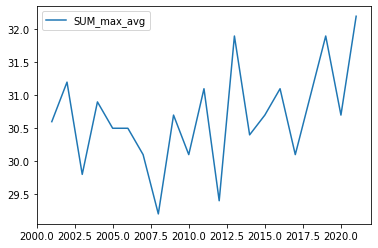

In [60]:
seasons.plot(y='SUM_max_avg')

In [ ]:
summers[21]

In [ ]:
poaw.loc[('2001-12-21'):('2001'+summer_end)]

In [ ]:
summers[19].plot(y='avg_temp')

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(summers[19]['avg_temp'])
plt.ylabel('Temperature C')    

plt.subplot(3,1,2)
plt.plot(summers[20]['avg_temp'])
plt.ylabel('Temperature C')

plt.subplot(3,1,3)
plt.plot(summers[18]['avg_temp'])
plt.ylabel('Temperature C')

In [ ]:
summers[2]['avg_temp'].mean()